In [32]:
import matplotlib.pyplot as plt
import numpy as np

In [33]:
##### Constants
KELVIN   = 273.15       # Kelvin temperature
R        = 8.314        # ideal gas constant
SBC      = 5.6697e-8    # Stefan-Boltzmann constant   W m-2 K-4
PSC      = 6.66e-4      # psychrometer constant
Cp       = 29.3         # specific heat of air    J mol-1 C-1
LAMBDA   = 44000.       # Latent heat of vaporization at 25 C J mol-1
##### Parameters for light
scatt   = 0.15          # leaf reflectance + transmittance
f       = 0.15          # correction factor
conv    = 4.57          # conversion from W m-2 to umol m-2 s-1
epsilon = 0.97          # leaf thermal emissivity
##### Other Common parameters
O2    = 210.            # O2 partial pressure (mbar=20.5kPa)
Kc25  = 404.9           # MM constant of Rubisco for CO2 at 25 from Bernacchi et al. (2001)
Ko25  = 278.4           # MM constant of Rubisco for O2 at 25 from Bernacchi et al. (2001)
Eac   = 79430.  # Activation energy for Kc from Bernacchi et al. (2001)
Eao   = 36380.  # Activation energy for Ko from Bernacchi et al. (2001)
g0    = 0.036    # residual stomatal conductance,  mol m-2 s-1
g1    = 10.0    # empirical coefficient of BWB model  이거
P     = 1.013   # conversion factor from ppmv to ubar (= 1013000 / 1000000) = 101.3 kPa = 1013 mbar


##########################################################
##### Parameters for Chinese cabbage from Experiment 2015
##########################################################
theta   = 0.7       # hyperbola parameter 이거
width   = 0.1        # leaf width (m) 이거
Vcm25   = 152.5     # Vcmax of CC at 25 C 이거
Jm25    = 238.6      # Jmax  of CC at 25 C 이거
TPU25   = 17.1       # 이거F
Rd25    = 1.7        # 이거
gamma25 = 42.8        #
Havcm   = 65330     # Ha
Hajm    = 57500     # Ha
Hdjm    = 439800.    # Hd
Svjm    = 1400      # Sv
Ear     = 46390.     # Ha
Eagamma = 37830.     # Ha
EaTPU   = 47100.     # Ha for TPU   from Kim and Leith(2003)

In [34]:
Ta = 25     # 온도 고정
Ic = 2000    # 광량 고정

Cinew = []   # 잎 내 Co2 농도

for i in range(1,1500):
    Cinew.append(i)

In [35]:
def tempParam1(k25, Ha, Hd, Sv, temp):
    a = (1+np.exp((Sv*(25+KELVIN)-Hd)/(R*(25+KELVIN))))/(1+np.exp((Sv*(temp+KELVIN)- Hd)/(R*(temp+KELVIN))))
    b = np.exp((Ha / (R * (25.+KELVIN))) * (1 - (25.+KELVIN) / (temp + KELVIN)))
    return (k25 * b * a)

def tempParam2(k25, Ha, temp):
    return  k25 * np.exp((Ha / (R * (25.+KELVIN)) * (1 - (25.+KELVIN) / (KELVIN + temp)))) # --> arrhenius function


Vcmax = tempParam2(k25=Vcm25, Ha=Havcm, temp=Ta)
Jmax = tempParam1(k25=Jm25, Ha=Hajm, Hd=Hdjm, Sv=Svjm, temp=Ta)
GammaStar = tempParam2(k25=gamma25, Ha=Eagamma, temp=Ta)
Kc = tempParam2(k25=Kc25, Ha=Eac, temp=Ta)
Ko = tempParam2(k25=Ko25, Ha=Eao, temp=Ta)
TPU = tempParam2(k25=TPU25, Ha=EaTPU, temp=Ta)
Rd = tempParam2(k25=Rd25, Ha=Ear, temp=Ta)


In [36]:
J2 = Ic * (1 - scatt) * (1 - f) / 2
J = ((J2 + Jmax) - np.sqrt((J2 + Jmax) ** 2 - 4 * J2 * Jmax * theta)) / (2 * theta)

In [37]:
## 광합성 모델식
Wc = []
Wj = []
Ws = []
Wp = []
W=[]
Rd = []
An = []
W_net = []

def minh(A, B, theta=0.7):  # hyperbolic minimum
    x = (A + B) * (A + B) - 4 * A * B * theta
    if (x < 0):
        res = min(A, B)
    else:
        res = ((A + B) - np.sqrt(x)) / (2 * theta)
    return res

for i in range(len(Cinew)):
    Wc.append(Vcmax * (Cinew[i] - GammaStar) / (Cinew[i] + Kc * (1 + O2 / Ko)))  # Rubisco-limited
    Wj.append(J * (Cinew[i] - GammaStar) / (4 * (Cinew[i] + 2 * GammaStar)))
    Ws.append(3 * TPU)
    Wp.append(minh(Wc[i], Wj[i], theta))
    W_net.append(min(Wc[i],Wj[i],Ws[i]))
    W.append(min(Wp[i], Ws[i]))  # min(Wp, Ws)
    Rd.append(0.015 * Vcmax)  # Dark respiration from Collatz(1991)
    An.append(W[i] - Rd)

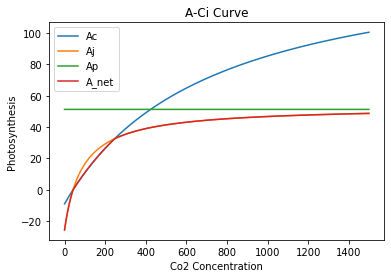

In [38]:
plt.plot(Wc, label = 'Ac')
plt.plot(Wj, label = 'Aj')
plt.plot(Ws, label = 'Ap')
plt.plot(W_net, label = 'A_net')
plt.title('A-Ci Curve')
plt.xlabel('Co2 Concentration')
plt.ylabel('Photosynthesis')
plt.legend()
# plt.show(https://user-images.githubusercontent.com/93086581/214617092-be421871-d1ce-4f98-8d6b-b90161f280bf.png)
plt.savefig(f'temp{Ta}.png')